# Pizza dataset analysis and price prediction

This projects analyzed data about pizza orders, each characterized by different features.<br>
The goal of this project is to get interesting insights from the data and develop a prediction model to predict the price of a pizza given some features.

The best performing model was XGBoost, with rmse= 77 rupiah and r2=0.925

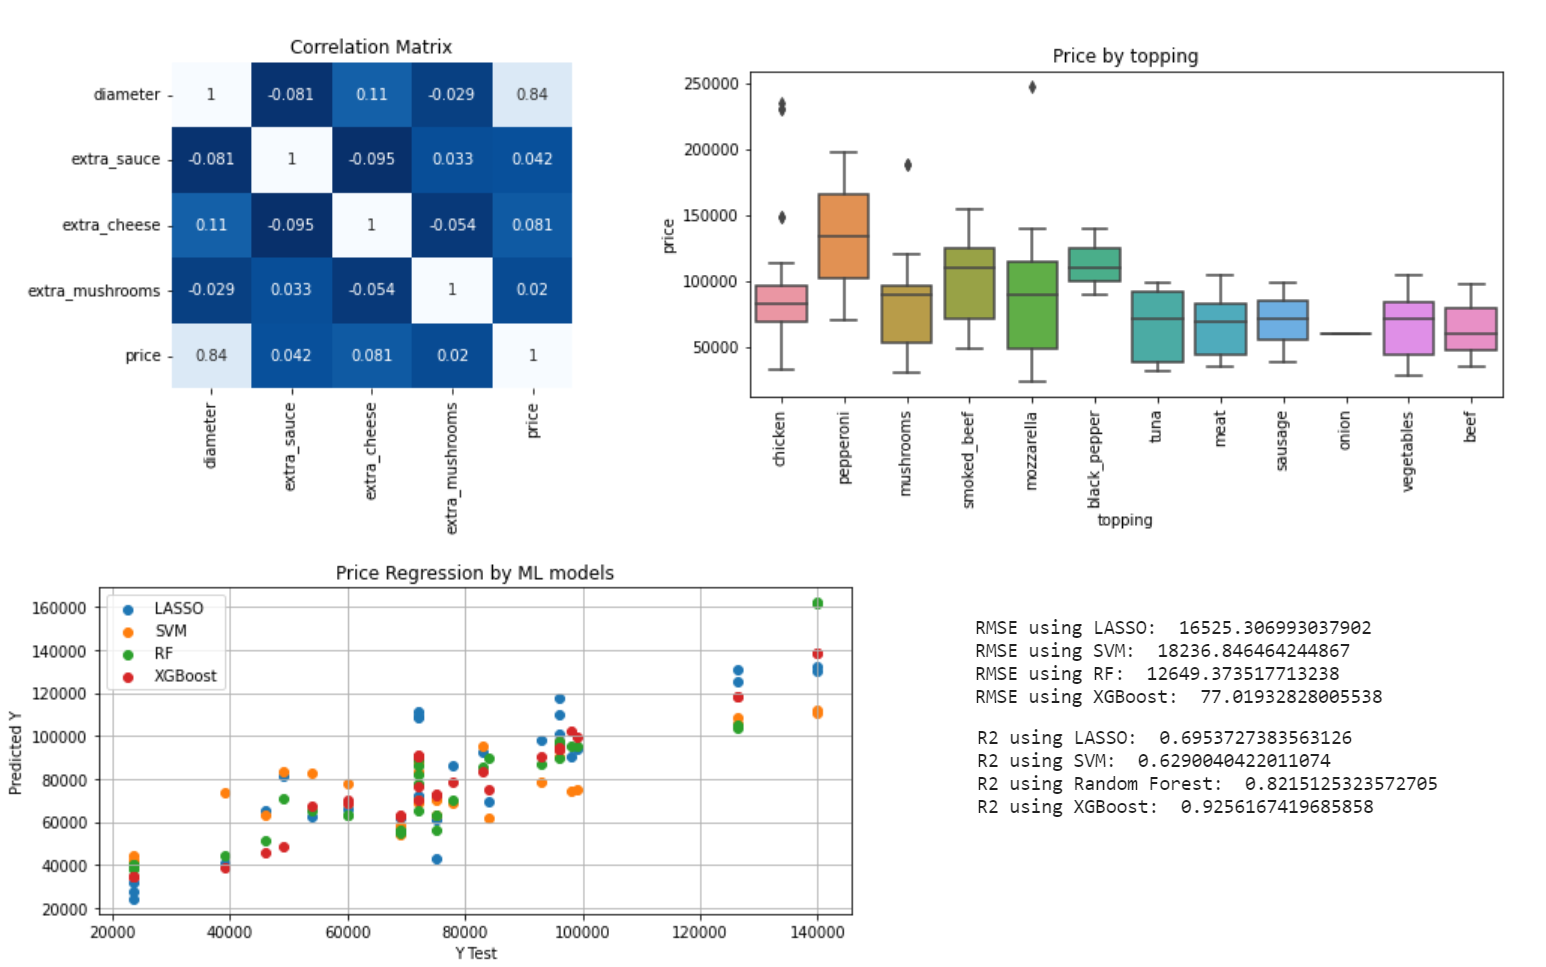

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/kaggle/input/pizza-price-prediction/pizza_v2.csv')
df.head()

In [ ]:
df.info()

We can already see that some numerical features such as price and diameter are saved as strings. They will be changed to int values.<br>

In [ ]:
df['price_rupiah'] = df['price_rupiah'].replace(',','')

In [ ]:
df.head()

In [ ]:
#create a new column that will include the price 
df['price'] = df['price_rupiah'].replace(',', '').apply(lambda x: x[2:])

In [ ]:
df = df.drop('price_rupiah', axis=1)

In [ ]:
df['price'] = df['price'].apply(lambda x: x.replace(',',''))

In [ ]:
df['price'] = df['price'].astype('int64')

In [ ]:
#remove 'inch' from the diameter column
df['diameter'] = df['diameter'].apply(lambda x: x.replace('inch',''))

In [ ]:
df['diameter'] = df['diameter'].astype('float')

In [ ]:
df.head()

Now it is possible to extract useful information of these numerical features:

In [ ]:
df.describe()

Diameter:<br>
The mean diameter is around 13 inches<br>
The minimum diameter is 8 inches<br>
The maximum diameter is 22 inches<br>

Price:<br>
The mean price is 87,151 rupiah (around 5.20 euros)<br>
The cheapest pizza in the dataset is 23,500 rupiah (1.40 euro)<br>
The most expensive one is 248,000 rupiah (14.77 euro)<br>

# Exploratory Data Analysis

### Numerical features analysis

In [ ]:
sns.displot(x='diameter', data=df, kde=False)

The diameter distribution is skewed right

In [ ]:
sns.displot(x='price', data=df)

The price distribition is right skewed as well.

### Topping analysis

In [ ]:
df['topping']

There seems to be two mispelling error: 'papperoni' instead of 'pepperoni' and 'black_papper' instead of 'black_pepper'. They will be corrected.

In [ ]:
df['topping'] = df['topping'].replace('papperoni','pepperoni')
df['topping'] = df['topping'].replace('black_papper','black_pepper')

In [ ]:
fig, ax=plt.subplots()
ax=sns.countplot(x='topping', data=df);
plt.xticks(rotation=90);
plt.show()

The most popular toppings among the pizzas are chicken, mushrooms, smoked_beef and mozzarella

In [ ]:
fig, ax = plt.subplots(figsize=(9,4))
sns.boxplot(x='topping', y='price', data=df)
plt.xticks(rotation=90);
ax.set_title('Price by topping');

From this plot we can say:<br>
Pepperoni pizza on average are more expensive than other pizzas.<br>
There are some outliers for mozzarella, mushrooms and chicken pizzas.<br>
It looks like there is just one onion pizza <br>


The only pizza with onions is:

In [ ]:
df[df['topping']=='onion']

While the most expensive pizza is:

In [ ]:
df[df['price'] > 240000]

### Size analysis

In [ ]:
df['size']

There seems to be a mispelled word: 'reguler' instead of 'regular'. It will be corrected.

In [ ]:
df['size'] = df['size'].replace('reguler','regular')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='size', y='price', data=df)
plt.xticks(rotation=90);

From this plot jumbo and regular pizzas seems to be more expensive. This sounds a bit weird for regular pizzas, since they should be cheaper than larger pizzas like Xl and large. This will be further analyzed later.

### Variant analysis

The different pizza variants are:

In [ ]:
df.variant.value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='variant', y='price', data=df)
plt.xticks(rotation=90);

From this plot we can say that:<br>
Double signature and double mix pizzas are more expensive than the other pizzas.<br>
In particular, double signature pizza date has a large variance.<br>
Classic and italian veggies are cheaper on average.<br>

It could be interesting to check if there is a correlation between the variance, toppings and size (categorical variables))

### Extra-toppings analysis

In [ ]:
df.info()

In [ ]:
sns.countplot(x='extra_sauce', data=df)

In [ ]:
sns.countplot(x='extra_cheese', data=df)

In [ ]:
sns.countplot(x='extra_mushrooms', data=df)

From these plots we can see that on avergae, most pizzas have extra toppings (among mushrooms, cheese and sauce)<br>
In particular, the most added toppings is extra cheese

### Is there a correlation between the extra toppings?

To check the correlation between the extra toppings, yes and no will be first substitued by 1 and 0

In [ ]:
df.replace(('yes', 'no'), (1, 0), inplace=True)

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='Blues_r');
plt.title('Correlation Matrix');

It looks like that diameter is highly correlated with price, while other features does not seem to be correlated.

Moreover, the size feature could be converted into a numerical feature and analyzed.

In [ ]:
sns.stripplot(x='size', y='diameter', data=df)

Small pizza have a diameter of 8 inches <br>
Medium pizza have a diameter of 12 inches <br>
Large pizza have a diameter of 14 inches <br>
XL pizza have a diameter of 17 inches <br>

Interestingly, for 'regular' and 'jumbo' pizzas, the diameter is not fixed.<br>
This will be further analyzed.<br>

So, what makes a pizza jumbo or regular?

### Jumbo sized pizza analysis

In [ ]:
df_jumbo = df[df['size'] == 'jumbo']
df_jumbo.head()

It looks like all these pizzas are from the company A, is that so?

In [ ]:
df_jumbo.company.value_counts()

It looks like there are only 15 jumbo pizzas in the dataset. In particular among these 15, 11 are from the company A while the other 4 are from company D

In [ ]:
df.company.value_counts()

For what concerns the original dataset, it seems to be banalced among different companies (from A to E)

In [ ]:
sns.displot(x='price', data=df_jumbo)

The minimum price is 125000 rupiah, which is higher than the average price of all pizzas ( around 87000 rupiah)

In [ ]:
sns.countplot(x='diameter', data=df_jumbo)

Among jumbo pizzas, the diamater seems higher than 17 inches (XL size pizzas diameter).<br>
What about those jumbo pizzas with a 16 inches diameter?

In [ ]:
df_jumbo[df_jumbo['diameter']==16]

These 4 pizzas have a small diameter despite being a jumbo pizza. They will be considered as outliers and dropped.

In [ ]:
df = df.loc[~((df['size'] == 'jumbo') & (df['diameter'] == 16)),:]

In [ ]:
sns.stripplot(x='size', y='diameter', data=df)

## Regular pizza analysis

In [ ]:
df_regular = df[df['size'] == 'regular']
df_regular.head()

In [ ]:
df_regular.info()

In [ ]:
df_regular.company.value_counts()

Like Jumbo pizzas, regular pizzas are only sold by company A and D

In [ ]:
sns.countplot(x='price', data=df_regular)

Most regular pizza sems to have a price around 90000 rupiah, which is close to the overall average (87000)

In [ ]:
sns.countplot(x='diameter', data=df_regular)

Most of regular pizza have a 12 inches diameter

What about the variant?

In [ ]:
df_regular.variant.value_counts()

The most popular variants are meat_lovers and double_mix.

It is still not clear what makes a regular pizza a regular pizza. The size should be related only to the diameter. For this reason, pizza with a regular size will be dropped from the dataframe.

In [ ]:
df = df.loc[~(df['size'] == 'regular'),:]

In [ ]:
df.head()

In [ ]:
df.info()

We dropped 20 regular pizzas and 4 jumbo pizzas (outliers)

# Pizza price prediction

Now it is possible to perform a regression on the price features of the pizzas.

## Encoding

In [ ]:
df.head()

First, we need to encode the categorical variables.<br>
Topping and variant will be encoded by One hot encoding since there is no order/hierarchy among them.<br>
Size will be encoded by label encoder since there actually exist an hierachy/order among sizes.

In [ ]:
df['size'].value_counts()

In [ ]:
df['size'] = df['size'].replace('small','0')
df['size'] = df['size'].replace('medium','1')
df['size'] = df['size'].replace('large','2')
df['size'] = df['size'].replace('XL','3')
df['size'] = df['size'].replace('jumbo','4')

A new dataframe with the encoded features will be created.

In [ ]:
encoded_df = df.copy()

In [ ]:
categorical_cols = ['topping', 'variant','company']
encoded_df=pd.get_dummies(encoded_df , columns=categorical_cols, drop_first=True)
encoded_df.head()

In [ ]:
encoded_df.head()

## Data preparation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [ ]:
X=encoded_df.drop('price', axis = 1).values

In [ ]:
y=encoded_df['price'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 69)

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(X_train)

In [ ]:
X_train = scaler.transform(X_train)          # Apply Standardization on X_train
X_test = scaler.transform(X_test)            # Apply Standardization on X_test

## Lasso model

In [ ]:
from sklearn.linear_model import Ridge, Lasso

In [ ]:
lm_lasso=Lasso(alpha = 10, max_iter = 1000000, tol = 1e-5)
lm_lasso.fit(X_train,y_train)
y_pred_lm_lasso = lm_lasso.predict(X_test)
mse_lm_lasso = mean_squared_error(y_test, y_pred_lm_lasso)
print("RMSE using LASSO: ", np.sqrt(mse_lm_lasso))

## SVM model

In [ ]:
from sklearn.svm import SVR

In [ ]:
param_SVM = {'C':np.arange(1000,20000,1000),
            'gamma':[0.001,0.001,0.01,0.015,0.03,0.05,0.1,0.2,0.5]}

In [ ]:
svr_model=SVR()

In [ ]:
cv_SVM = GridSearchCV(estimator=svr_model, param_grid = param_SVM, cv = 5)

In [ ]:
cv_SVM.fit(X_train,y_train)

In [ ]:
y_pred_SVM = cv_SVM.predict(X_test)

In [ ]:
# Compute and print the metrics
print("Tuned SVM parameters: {}".format(cv_SVM.best_params_))

In [ ]:
mse_SVM = mean_squared_error(y_test, y_pred_SVM)
print("RMSE using SVM: ", np.sqrt(mse_SVM))

## Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {
    'max_depth': np.arange(10,1000,10),
    'max_features': np.arange(10,1000,10),
    'n_estimators': np.arange(10,1000,10)
}

In [ ]:
rf = RandomForestRegressor(n_estimators=80, max_depth=100, max_features=10)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
y_pred_rf = rf.predict(X_test)

In [ ]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("RMSE using RF: ", np.sqrt(mse_rf))

In [ ]:
print("RF R2 score :", r2_score(y_test,y_pred_rf))

## XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor(n_estimators=500, learning_rate=0.01) 

In [ ]:
xgb.fit(X_train, y_train) 

In [ ]:
y_pred_xgb = xgb.predict(X_test) 

In [ ]:
mse_xgb = mean_absolute_error(y_pred_xgb, y_test)
print("RMSE:" , np.sqrt(mse_xgb))

In [ ]:
print("XGBoost R2 score :", r2_score(y_test,y_pred_xgb))

In [ ]:
plt.figure(figsize = (9,4))
plt.scatter(y_test, y_pred_lm_lasso, label='LASSO')
plt.scatter(y_test, y_pred_SVM, label='SVM')
plt.scatter(y_test, y_pred_rf, label='RF')
plt.scatter(y_test, y_pred_xgb, label='XGBoost')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.title('Price Regression by ML models')
plt.legend(loc='upper left');
plt.grid()

In [ ]:
print("RMSE using LASSO: ", np.sqrt(mse_lm_lasso))
print("RMSE using SVM: ", np.sqrt(mse_SVM))
print("RMSE using RF: ", np.sqrt(mse_rf))
print("RMSE using XGBoost: ", np.sqrt(mse_xgb))

In [ ]:
from sklearn.metrics import r2_score
print("R2 using LASSO: ", r2_score(y_test, y_pred_lm_lasso))
print("R2 using SVM: ",  r2_score(y_test, y_pred_SVM))
print("R2 using Random Forest: ",  r2_score(y_test, y_pred_rf))
print("R2 using XGBoost: ",  r2_score(y_test, y_pred_xgb))

We get the best result in terms of RMSE and R2 by using XGBoost regressor.